#Tools

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import seaborn as sns
from google.colab import files
from google.colab import drive
from datetime import datetime
from datetime import date
import re
from sklearn.metrics import  accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
import warnings
import itertools

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def is_business_day(this_date):
    week_day = -1
    if (this_date in calendar["Date"].values):
      week_day=calendar["Country 1"][calendar["Date"] == this_date].values[0]
    return week_day



In [114]:
def built_SARIMA (order, seasonal_order,series):
    mod = sm.tsa.statespace.SARIMAX(series,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.aic)
    print(results)
    print(results.summary().tables[1])
    return results

In [108]:
def predict(model,start_string = '2017-11-15', end_string = '2018-02-22', series = y_complete):

  pred = model.get_prediction(start=pd.to_datetime(start_string), end=pd.to_datetime(end_string),dynamic=False)
  pred_ci = pred.conf_int()
  print(pred.predicted_mean)
  ax = series[pd.to_datetime(end_string)-pd.DateOffset(months=6):pd.to_datetime(end_string)+pd.DateOffset(months=1)].plot(label='observed')
  pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=.2)
  ax.set_xlabel('Date')
  ax.set_ylabel('Monthly Sales')
  plt.legend()
  plt.show()
  return pred

In [118]:
def make_forcast(start_date="2020-01-01", end_date_train='2017-11-16', end_forecast= '2017-11-22'):
 
    model =  built_SARIMA(order=(3, 1, 5),seasonal_order=(1, 1, 1, 7), series= y_complete[:pd.to_datetime(end_date_train)])
    return predict(model = model, start_string = start_date, end_string = end_forecast, series = y_complete)
    

In [4]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [5]:
#def calculate_cofidence()

# Loading data




In [6]:
drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/Retail/"
forecast_data = pd.read_excel(path + "Forecasts.xlsx", engine = "openpyxl")
daily_sales_data = pd.read_excel(path + "Daily Sales.xlsx", sheet_name= "Daily Sales")
calendar_weekdays = pd.read_excel(path + "Working Days Calendar.xlsx", sheet_name= "Weekdays", skiprows=4, usecols="B:K")
calendar = pd.read_excel(path + "Working Days Calendar.xlsx", sheet_name= "Calendar", skiprows=4, usecols="A:I")
ACT_LO_data = pd.read_excel(path + "ACT and LO Monthly.xlsx")

Mounted at /content/drive


#Explore and Restructure Data


In [7]:
daily_sales_data.head()

,Country,Posting Date,Brand,Daily Sales
0,Country 1,02.01.2015,Brand A,30785.21560
1,Country 1,05.01.2015,Brand A,18256.02366
2,Country 1,06.01.2015,Brand A,24168.04468
3,Country 1,07.01.2015,Brand A,3858.64932
4,Country 1,12.01.2015,Brand A,1229.33310


In [8]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1155 non-null   object        
 1   Date        1155 non-null   datetime64[ns]
 2   Month-Year  1155 non-null   datetime64[ns]
 3   Day         1155 non-null   object        
 4   Year        1155 non-null   float64       
 5   Month       1155 non-null   int64         
 6   Month.1     1155 non-null   object        
 7   Day.1       1155 non-null   int64         
 8   Country 1   1155 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 81.3+ KB


In [9]:
calendar["Date"]=calendar["Date"].dt.date

In [10]:
calendar_weekdays

,Month-Year,#Mon,#Tue,#Wed,#Thu,#Fri,#Sat,#Sun,Total Weekdays,Country 1
0,2015-01-01,4.0,4.0,4.0,5.0,5.0,5.0,4.0,31,21.0
1,2015-02-02,4.0,4.0,4.0,4.0,4.0,4.0,4.0,28,20.0
2,2015-03-03,5.0,5.0,4.0,4.0,4.0,4.0,5.0,31,22.0
3,2015-04-04,4.0,4.0,5.0,5.0,4.0,4.0,4.0,30,22.0
4,2015-05-05,4.0,4.0,4.0,4.0,5.0,5.0,5.0,31,20.0
5,2015-06-06,5.0,5.0,4.0,4.0,4.0,4.0,4.0,30,22.0
6,2015-07-07,4.0,4.0,5.0,5.0,5.0,4.0,4.0,31,23.0
7,2015-08-08,5.0,4.0,4.0,4.0,4.0,5.0,5.0,31,21.0
8,2015-09-09,4.0,5.0,5.0,4.0,4.0,4.0,4.0,30,22.0
9,2015-10-10,4.0,4.0,4.0,5.0,5.0,5.0,4.0,31,22.0


In [11]:
calendar_weekdays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Month-Year      38 non-null     datetime64[ns]
 1   #Mon            38 non-null     float64       
 2   #Tue            38 non-null     float64       
 3   #Wed            38 non-null     float64       
 4   #Thu            38 non-null     float64       
 5   #Fri            38 non-null     float64       
 6   #Sat            38 non-null     float64       
 7   #Sun            38 non-null     float64       
 8   Total Weekdays  38 non-null     int64         
 9   Country 1       38 non-null     float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 3.1 KB


##ACT-LO Data


First take a look at the distributions of LO and ACT


In [12]:
ACT_LO_data.head()

,Submission,Year,Month,Country 1 - Brand A
0,Actual,2015,1,224134.6
1,Actual,2015,2,184817.6
2,Actual,2015,3,249555.0
3,Actual,2015,4,245542.0
4,Actual,2015,5,221473.8


In [13]:
ACT_LO_data["Date"] = ACT_LO_data['Year'].astype(str) + "/" + ACT_LO_data["Month"].apply(lambda x: str(x).rjust(2, '0'))

In [14]:
ACT_LO_data["Date"]

0     2015/01
1     2015/02
2     2015/03
3     2015/04
4     2015/05
       ...   
67    2017/10
68    2017/11
69    2017/12
70    2018/01
71    2018/02
Name: Date, Length: 72, dtype: object

In [15]:
Actual_data = ACT_LO_data[ACT_LO_data["Submission"] == "Actual"]
LO_data = ACT_LO_data[ACT_LO_data["Submission"] != "Actual"]
ACT_LO_data["Act/LO"]=ACT_LO_data["Submission"].apply(lambda x: "ACT" if  x == "Actual" else "LO")

In [16]:
ACT_LO_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Submission           72 non-null     object 
 1   Year                 72 non-null     int64  
 2   Month                72 non-null     int64  
 3   Country 1 - Brand A  72 non-null     float64
 4   Date                 72 non-null     object 
 5   Act/LO               72 non-null     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 3.5+ KB


We could observe no nan values in ACT_LO_data

In [17]:
ACT_LO_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,72.0,2016.027778,0.871654,2015.0,2015.00,2016.000,2017.000,2018.0
Month,72.0,6.222222,3.465005,1.0,3.00,6.000,9.000,12.0
Country 1 - Brand A,72.0,272215.294477,38109.303473,184817.6,248126.75,273972.237,300029.057,350088.0


In [18]:
LO_data.head()

,Submission,Year,Month,Country 1 - Brand A,Date
34,LO Jan 15 Total,2015,1,224175.600000,2015/01
35,LO Feb 15 Total,2015,2,198122.288255,2015/02
36,LO Mar 15 Total,2015,3,255465.428000,2015/03
37,LO Apr 15 Total,2015,4,232068.578168,2015/04
38,LO May 15 Total,2015,5,216181.778528,2015/05


In [19]:
Actual_data.head()

,Submission,Year,Month,Country 1 - Brand A,Date
0,Actual,2015,1,224134.6,2015/01
1,Actual,2015,2,184817.6,2015/02
2,Actual,2015,3,249555.0,2015/03
3,Actual,2015,4,245542.0,2015/04
4,Actual,2015,5,221473.8,2015/05


In [20]:
#[ACT_LO_data['Year']!=2018]

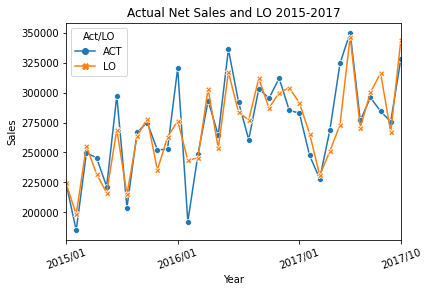

In [21]:
sea_plot = sns.lineplot(data=ACT_LO_data, x="Date", y="Country 1 - Brand A", hue="Act/LO", style="Act/LO",
    markers=True, dashes=False)
sea_plot.set_xlim("2015/01","2017/10")
sea_plot.set(xlabel ="Year", ylabel = "Sales", title ='Actual Net Sales and LO 2015-2017')

plt.xticks([0, 11,23, 33],["2015/01", "2016/01","2017/01","2017/10"], rotation =20)
plt.show()

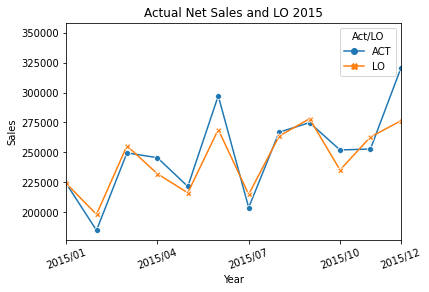

In [22]:
sea_15 = sns.lineplot(data=ACT_LO_data, x="Date", y="Country 1 - Brand A", hue="Act/LO", style="Act/LO",
    markers=True, dashes=False)
sea_15.set_xlim("2015/01","2015/12")
sea_15.set(xlabel ="Year", ylabel = "Sales", title ='Actual Net Sales and LO 2015')

plt.xticks([0, 3,6, 9,11],["2015/01","2015/04", "2015/07","2015/10","2015/12"], rotation =20)
plt.show()

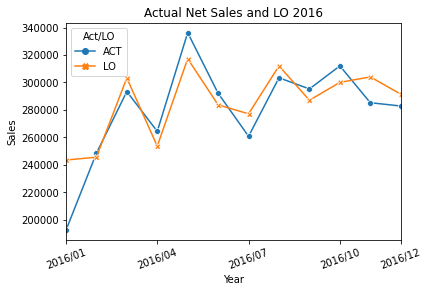

In [23]:
sea_16 = sns.lineplot(data=ACT_LO_data[ACT_LO_data["Year"] == 2016], x="Date", y="Country 1 - Brand A", hue="Act/LO", style="Act/LO",
    markers=True, dashes=False)
sea_16.set_xlim("2016/01","2016/12")
sea_16.set(xlabel ="Year", ylabel = "Sales", title ='Actual Net Sales and LO 2016')

plt.xticks([0,3,6,9,11],["2016/01","2016/04", "2016/07","2016/10","2016/12"], rotation =20)
plt.show()

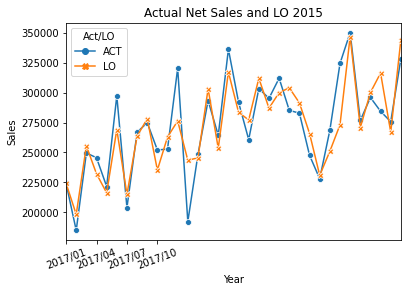

In [24]:
sea_17 = sns.lineplot(data=ACT_LO_data, x="Date", y="Country 1 - Brand A", hue="Act/LO", style="Act/LO",
    markers=True, dashes=False)
sea_17.set_xlim("2017/01","2017/10")
sea_17.set(xlabel ="Year", ylabel = "Sales", title ='Actual Net Sales and LO 2015')

plt.xticks([0, 3,6, 9],["2017/01","2017/04", "2017/07","2017/10"], rotation =20)
plt.show()

bei 2016 und 2017 gibts ein problem!


##Daily Sales Data

In [25]:
daily_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       634 non-null    object 
 1   Posting Date  634 non-null    object 
 2   Brand         634 non-null    object 
 3   Daily Sales   634 non-null    float64
dtypes: float64(1), object(3)
memory usage: 19.9+ KB


In [26]:
daily_sales_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Daily Sales,634.0,15933.469617,14196.766766,-9693.27402,352.01264,15609.84877,25639.132945,84258.82528


In [27]:
daily_sales_data["Date"] = pd.to_datetime(daily_sales_data["Posting Date"], dayfirst=True).dt.date

In [28]:
print(daily_sales_data['Date'].min())
print(daily_sales_data['Date'].max())

2015-01-02
2018-02-23


In [29]:
daily_sales_data= daily_sales_data.drop(["Brand","Country"],axis =1)

In [30]:
daily_sales_data.index

RangeIndex(start=0, stop=634, step=1)

In [31]:
daily_sales_data["Is business day"] = daily_sales_data["Date"].map(is_business_day)

In [32]:
daily_sales_data.groupby(["Is business day"]).count()

,Posting Date,Daily Sales,Date
Is business day,,,
0.0,5,5,5
1.0,629,629,629


5 daily sales reports where done on a holiday, maybe should be deleted

In [33]:
daily_sales_data["Year"] = pd.DatetimeIndex(daily_sales_data["Date"]).year
daily_sales_data["Month"] = pd.DatetimeIndex(daily_sales_data["Date"]).month

In [34]:
monthly_sales = daily_sales_data.groupby(["Year", "Month"]).sum()
monthly_sales

Daily Sales  Is business day
Year Month                               
2015 1      224134.57218             16.0
     2      184817.70354             14.0
     3      249562.93872             16.0
     4      245558.33046             18.0
     5      221473.78012             14.0
     6      297270.66752             18.0
     7      203844.75510             16.0
     8      266867.15804             15.0
     9      274851.57568             17.0
     10     252015.34226             20.0
     11     252790.56088             14.0
     12     320404.45784             16.0
2016 1      192173.23452             18.0
     2      248322.61024             18.0
     3      293308.06910             20.0
     4      264299.46708             17.0
     5      336246.94764             18.0
     6      292032.95886             17.0
     7      260712.61958             15.0
     8      303357.78318             20.0
     9      295218.13360             17.0
     10     312006.58854             20.0
     11     285187.23298             18.0
     12     282776.72720             16.0
2017 1      247539.18708             17.0
     2      227948.50734             17.0
     3      268514.12380             18.0
     4      324387.94898             17.0
     5      350088.12480             17.0
     6      276677.24216             18.0
     7      295913.41554             15.0
     8      284361.39856             17.0
     9      275685.91100             13.0
     10     328168.08148             20.0
     11     222550.90186             15.0
     12     208955.08246             12.0
2018 1      274013.38642             14.0
     2      157782.21058             11.0

In [35]:
monthly_data_count = daily_sales_data.groupby(["Year", "Month"]).count()
monthly_data_count

Posting Date  Daily Sales  Date  Is business day
Year Month                                                  
2015 1                17           17    17               17
     2                14           14    14               14
     3                16           16    16               16
     4                18           18    18               18
     5                15           15    15               15
     6                18           18    18               18
     7                16           16    16               16
     8                15           15    15               15
     9                17           17    17               17
     10               20           20    20               20
     11               14           14    14               14
     12               16           16    16               16
2016 1                19           19    19               19
     2                18           18    18               18
     3                20           20    20               20
     4                17           17    17               17
     5                18           18    18               18
     6                17           17    17               17
     7                16           16    16               16
     8                20           20    20               20
     9                17           17    17               17
     10               20           20    20               20
     11               18           18    18               18
     12               17           17    17               17
2017 1                17           17    17               17
     2                17           17    17               17
     3                18           18    18               18
     4                17           17    17               17
     5                17           17    17               17
     6                18           18    18               18
     7                15           15    15               15
     8                17           17    17               17
     9                13           13    13               13
     10               20           20    20               20
     11               15           15    15               15
     12               12           12    12               12
2018 1                14           14    14               14
     2                11           11    11               11

## Try filling up holiday gaps in daily sales data

In [36]:

print(daily_sales_data["Date"][0])
print(calendar["Date"][0])

2015-01-02
2015-01-01


In [37]:
complete_series = pd.merge(calendar,daily_sales_data, on="Date", how = "left")


In [38]:
complete_series.head()

,Unnamed: 0,Date,Month-Year,Day,Year_x,Month_x,Month.1,Day.1,Country 1,Posting Date,Daily Sales,Is business day,Year_y,Month_y
0,Jan2015,2015-01-01,2015-01-01,Thursday,2015.0,1,Jan,1,0.0,NaN,NaN,NaN,NaN,NaN
1,Jan2015,2015-01-02,2015-01-02,Friday,2015.0,1,Jan,2,1.0,02.01.2015,30785.21560,1.0,2015.0,1.0
2,Jan2015,2015-01-03,2015-01-03,Saturday,2015.0,1,Jan,3,0.0,NaN,NaN,NaN,NaN,NaN
3,Jan2015,2015-01-04,2015-01-04,Sunday,2015.0,1,Jan,4,0.0,NaN,NaN,NaN,NaN,NaN
4,Jan2015,2015-01-05,2015-01-05,Monday,2015.0,1,Jan,5,1.0,05.01.2015,18256.02366,1.0,2015.0,1.0


In [39]:
complete_series= complete_series.drop(["Month.1", "Posting Date", "Is business day", "Year_y",	"Month_y"], axis = 1)

In [40]:
complete_series["Daily Sales"]=complete_series["Daily Sales"].fillna(0)

In [41]:
y_complete = complete_series[["Daily Sales", "Date"]]

In [42]:
y_complete["Date"]=pd.to_datetime(y_complete["Date"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
y_complete= y_complete.set_index("Date")
y_complete.sort_index()

,Daily Sales
Date,
2015-01-01,0.00000
2015-01-02,30785.21560
2015-01-03,0.00000
2015-01-04,0.00000
2015-01-05,18256.02366
...,...
2018-02-24,0.00000
2018-02-25,0.00000
2018-02-26,0.00000


In [44]:
#drop values we dont need
y_complete[:"2018-02-23"]

,Daily Sales
Date,
2015-01-01,0.00000
2015-01-02,30785.21560
2015-01-03,0.00000
2015-01-04,0.00000
2015-01-05,18256.02366
...,...
2018-02-19,25179.30168
2018-02-20,13206.75222
2018-02-21,10384.84878


##Visualize time series

In [45]:
daily_sales_data= daily_sales_data.set_index("Date")

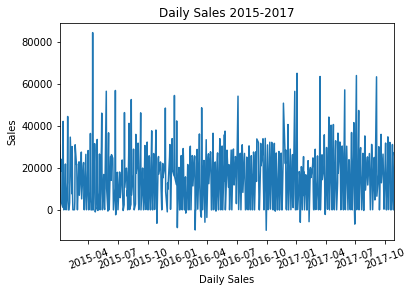

In [46]:

sea_plot_daily = sns.lineplot(data=daily_sales_data, x="Date", y="Daily Sales")
sea_plot_daily.set_xlim(pd.to_datetime("2015-01-02"),pd.to_datetime("2017-10-30"))
sea_plot_daily.set(xlabel ="Daily Sales", ylabel = "Sales", title ='Daily Sales 2015-2017')

plt.xticks(rotation =20)
plt.show()

The mean looks constant.
We will take a closer look at the years.

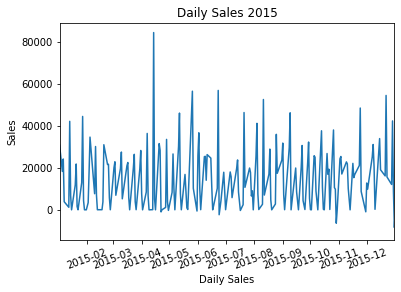

In [47]:
sea_plot_daily = sns.lineplot(data=daily_sales_data, x="Date", y="Daily Sales")
sea_plot_daily.set_xlim(pd.to_datetime("2015-01-02"),pd.to_datetime("2015-12-31"))
sea_plot_daily.set(xlabel ="Daily Sales", ylabel = "Sales", title ='Daily Sales 2015')

plt.xticks(rotation =20)
plt.show()

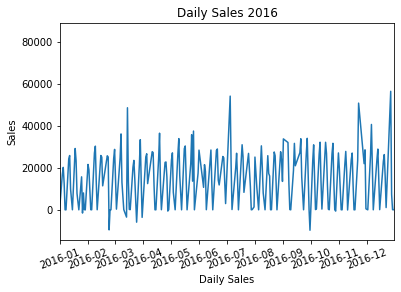

In [48]:
sea_plot_daily = sns.lineplot(data=daily_sales_data, x="Date", y="Daily Sales")
sea_plot_daily.set_xlim(pd.to_datetime("2016-01-01"),pd.to_datetime("2016-12-31"))
sea_plot_daily.set(xlabel ="Daily Sales", ylabel = "Sales", title ='Daily Sales 2016')

plt.xticks(rotation =20)
plt.show()

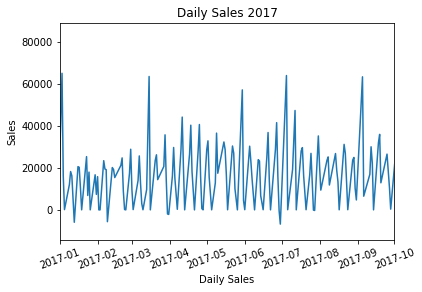

In [49]:
sea_plot_daily = sns.lineplot(data=daily_sales_data, x="Date", y="Daily Sales")
sea_plot_daily.set_xlim(pd.to_datetime("2017-01-01"),pd.to_datetime("2017-10-01"))
sea_plot_daily.set(xlabel ="Daily Sales", ylabel = "Sales", title ='Daily Sales 2017')

plt.xticks(rotation =20)
plt.show()

In [50]:
daily_sales_data["Daily Sales"].shape

(634,)

In [51]:
daily_sales_data.index=pd.to_datetime(daily_sales_data.index)

In [52]:
daily_sales_data.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15',
               '2015-01-19', '2015-01-20',
               ...
               '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-12',
               '2018-02-13', '2018-02-14', '2018-02-19', '2018-02-20',
               '2018-02-21', '2018-02-23'],
              dtype='datetime64[ns]', name='Date', length=634, freq=None)

In [53]:
y=daily_sales_data["Daily Sales"]
y.sort_index(inplace=True)

In [54]:
y[:pd.to_datetime("2015-12-31")]

Date
2015-01-02    30785.21560
2015-01-05    18256.02366
2015-01-06    24168.04468
2015-01-07     3858.64932
2015-01-12     1229.33310
                 ...     
2015-12-23    15621.23038
2015-12-28    12070.09996
2015-12-29    42273.66628
2015-12-30     8646.21500
2015-12-31    -8423.28082
Name: Daily Sales, Length: 196, dtype: float64

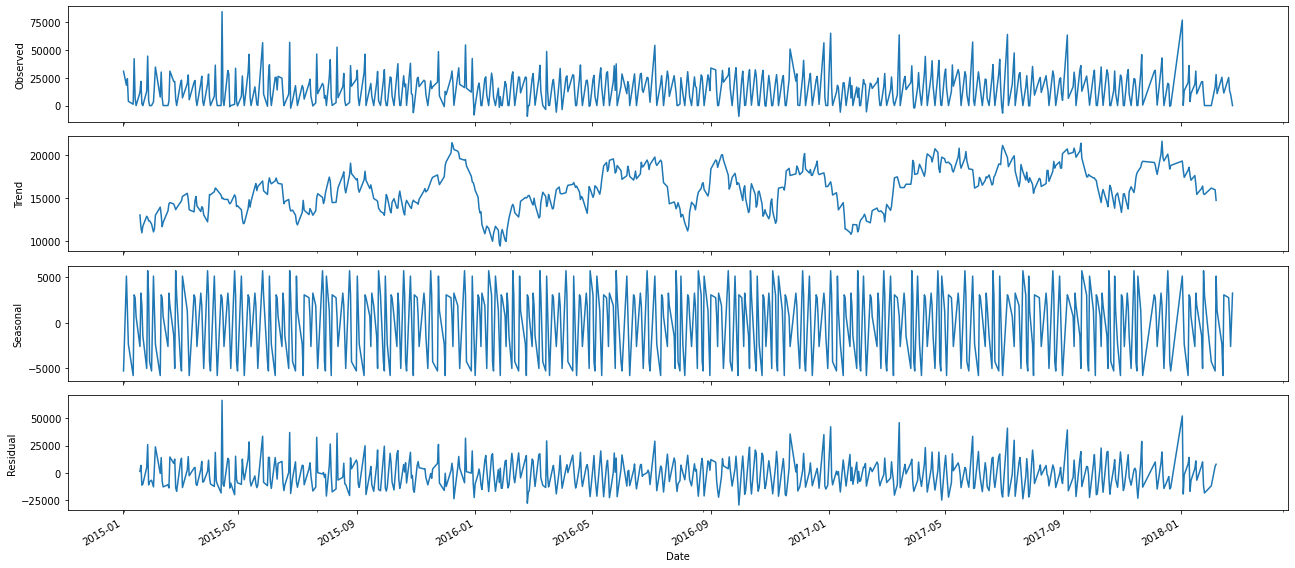

In [55]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive', freq=16)
fig = decomposition.plot()
plt.show()

lets take a look at it for just one year

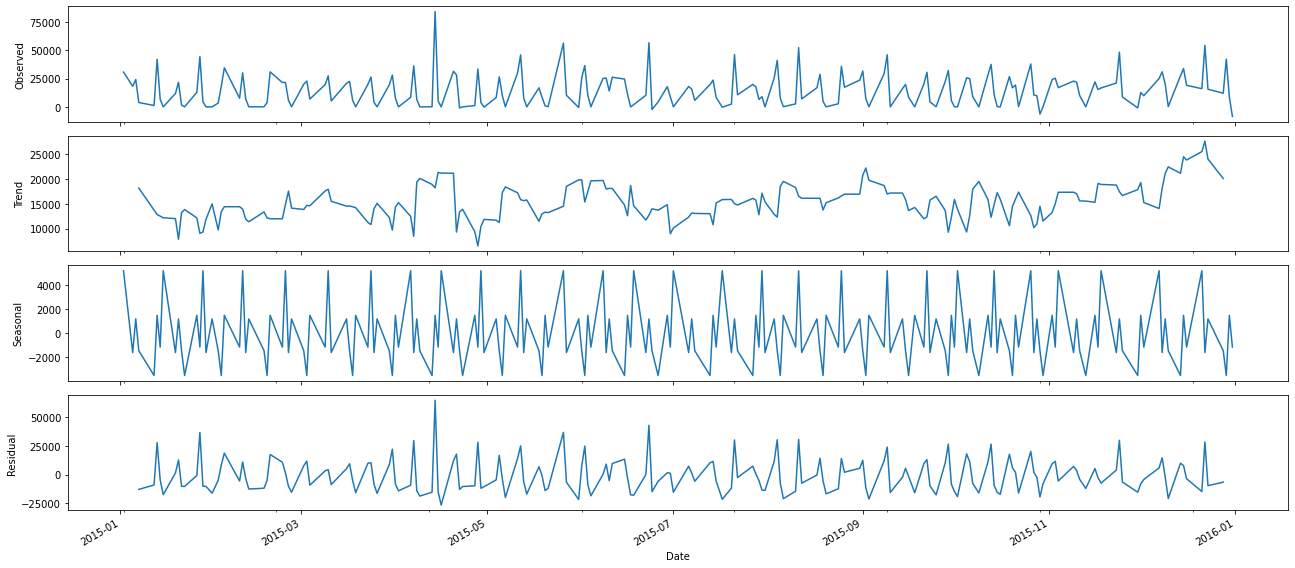

In [56]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y[:pd.to_datetime("2015-12-31")], model='additive', freq=7)
fig = decomposition.plot()
plt.show()

We can observe a clear seasonal pattern and unstable behaviour. It looks like the seasonal pattern is monthly.
Additonally we will perform a Dickey Fuller Test.

In [57]:
perform_adf_test(y)

ADF Statistic: -13.619253
p-value: 0.000000


We obtain a p value that is < 0.5. So we can reject the null hypothesis that it has unit roots.

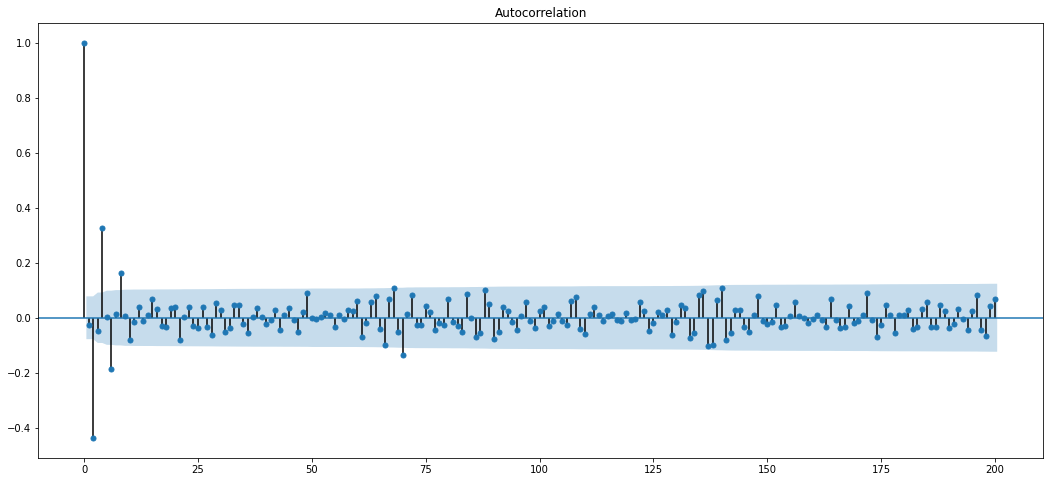

In [58]:
acf_plot = plot_acf(y, lags=200)

We can observe autocorelation.


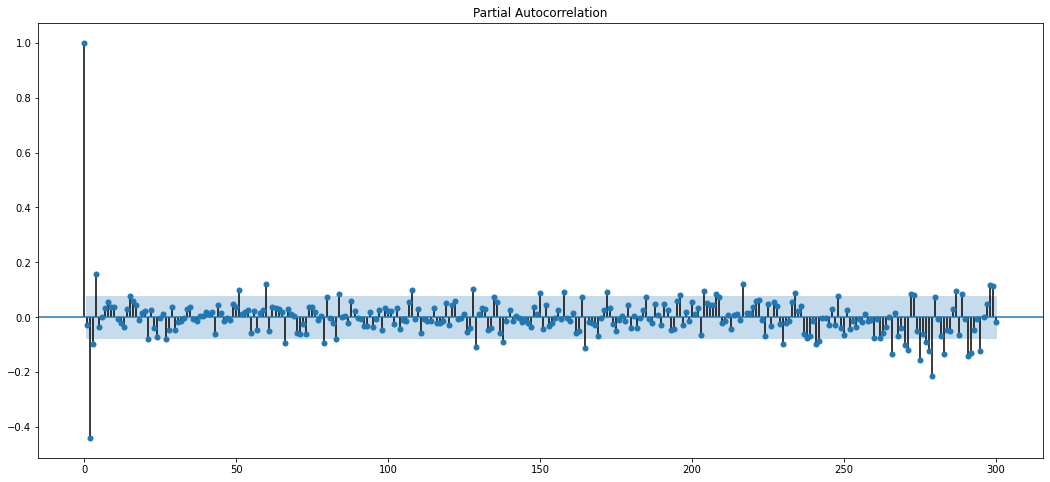

In [59]:
pacf_plot = plot_pacf(y, lags= 300)

We can observe more significant lags after approximately 250 lags, this hints to seasonality. 


##Visualize  complete time series

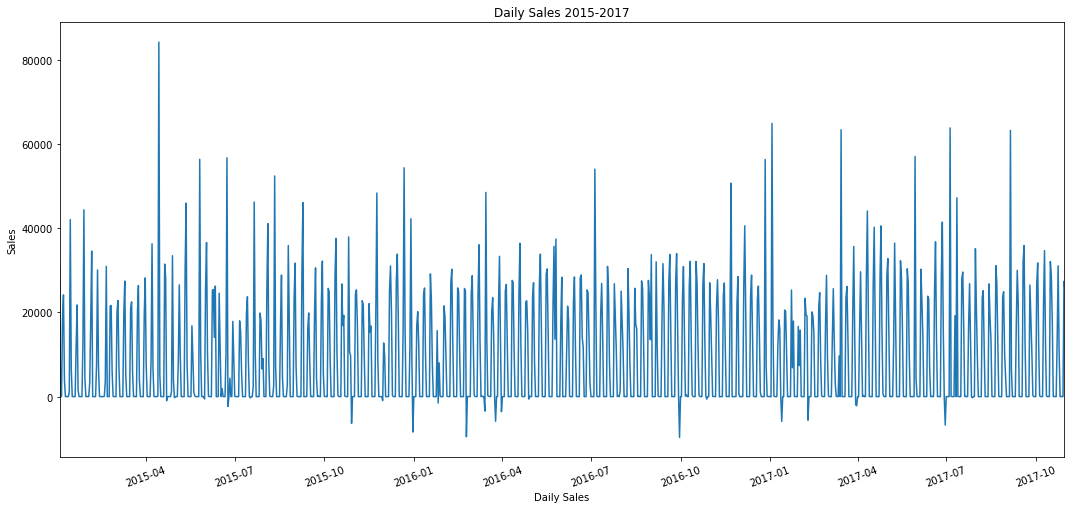

In [60]:

sea_plot_daily = sns.lineplot(data=y_complete, x="Date", y="Daily Sales")
sea_plot_daily.set_xlim(pd.to_datetime("2015-01-02"),pd.to_datetime("2017-10-30"))
sea_plot_daily.set(xlabel ="Daily Sales", ylabel = "Sales", title ='Daily Sales 2015-2017')

plt.xticks(rotation =20)
plt.show()

The mean looks constant.
We will take a closer look at the years.

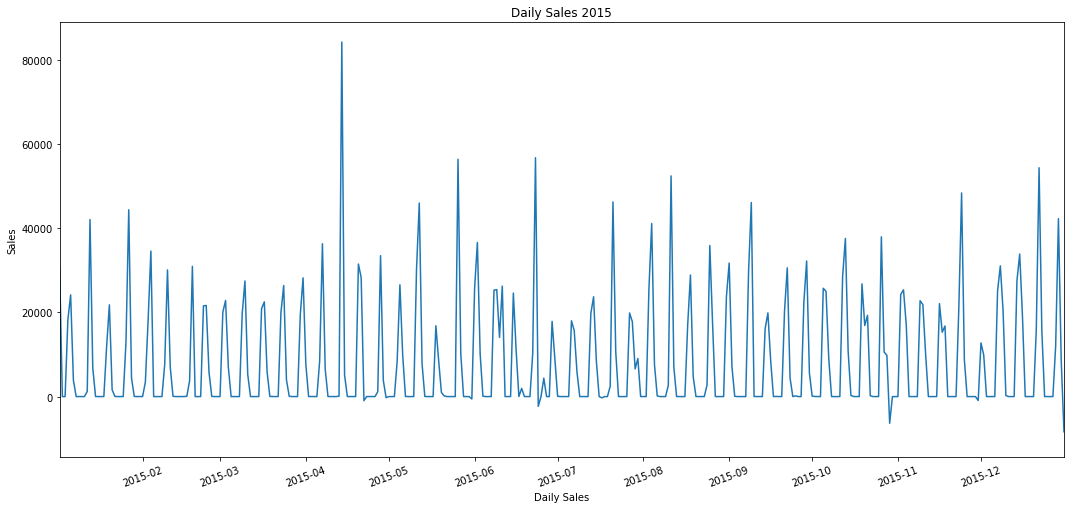

In [61]:
sea_plot_daily = sns.lineplot(data=y_complete, x="Date", y="Daily Sales")
sea_plot_daily.set_xlim(pd.to_datetime("2015-01-02"),pd.to_datetime("2015-12-31"))
sea_plot_daily.set(xlabel ="Daily Sales", ylabel = "Sales", title ='Daily Sales 2015')

plt.xticks(rotation =20)
plt.show()

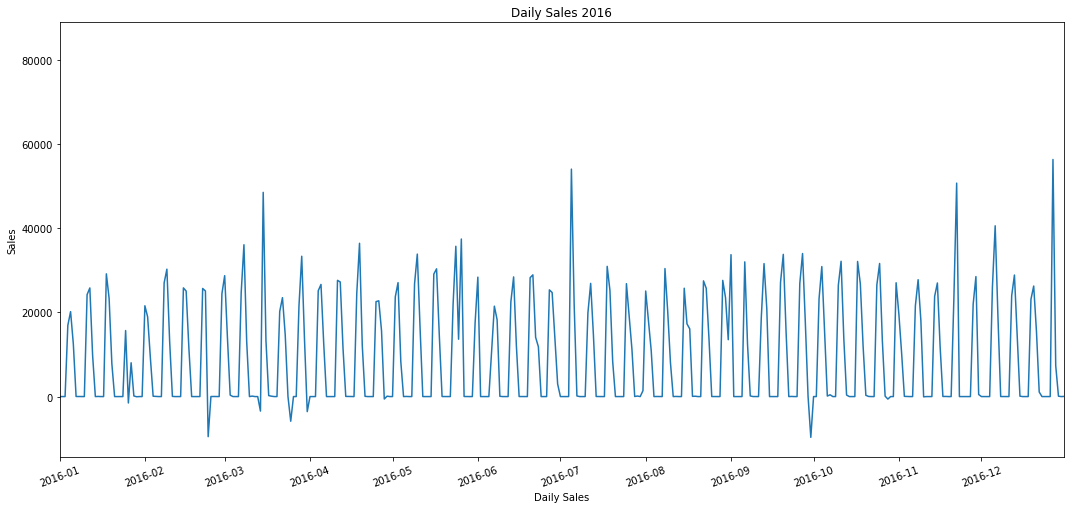

In [62]:
sea_plot_daily = sns.lineplot(data=y_complete, x="Date", y="Daily Sales")
sea_plot_daily.set_xlim(pd.to_datetime("2016-01-01"),pd.to_datetime("2016-12-31"))
sea_plot_daily.set(xlabel ="Daily Sales", ylabel = "Sales", title ='Daily Sales 2016')

plt.xticks(rotation =20)
plt.show()

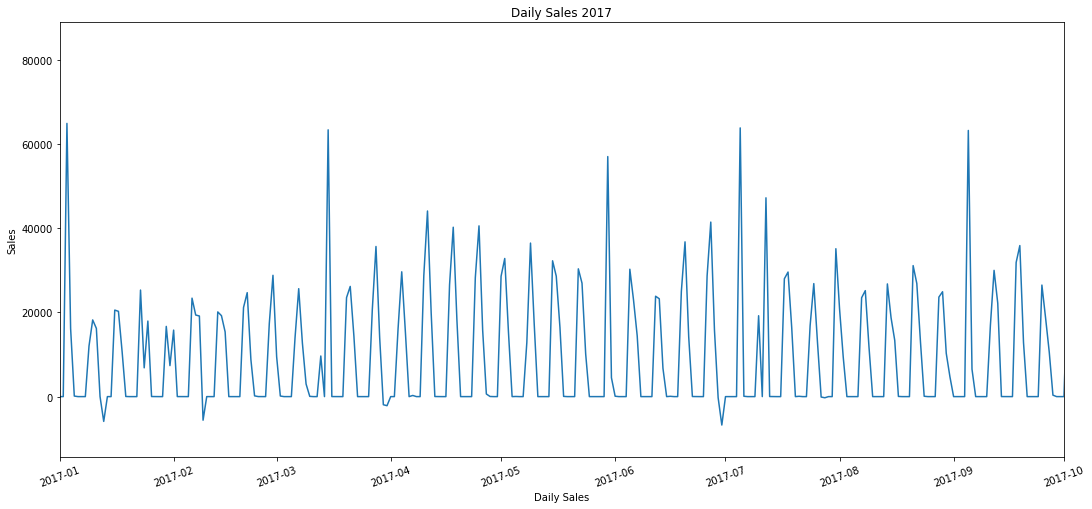

In [63]:
sea_plot_daily = sns.lineplot(data=y_complete, x="Date", y="Daily Sales")
sea_plot_daily.set_xlim(pd.to_datetime("2017-01-01"),pd.to_datetime("2017-10-01"))
sea_plot_daily.set(xlabel ="Daily Sales", ylabel = "Sales", title ='Daily Sales 2017')

plt.xticks(rotation =20)
plt.show()

In [64]:
y_complete.shape

(1155, 1)

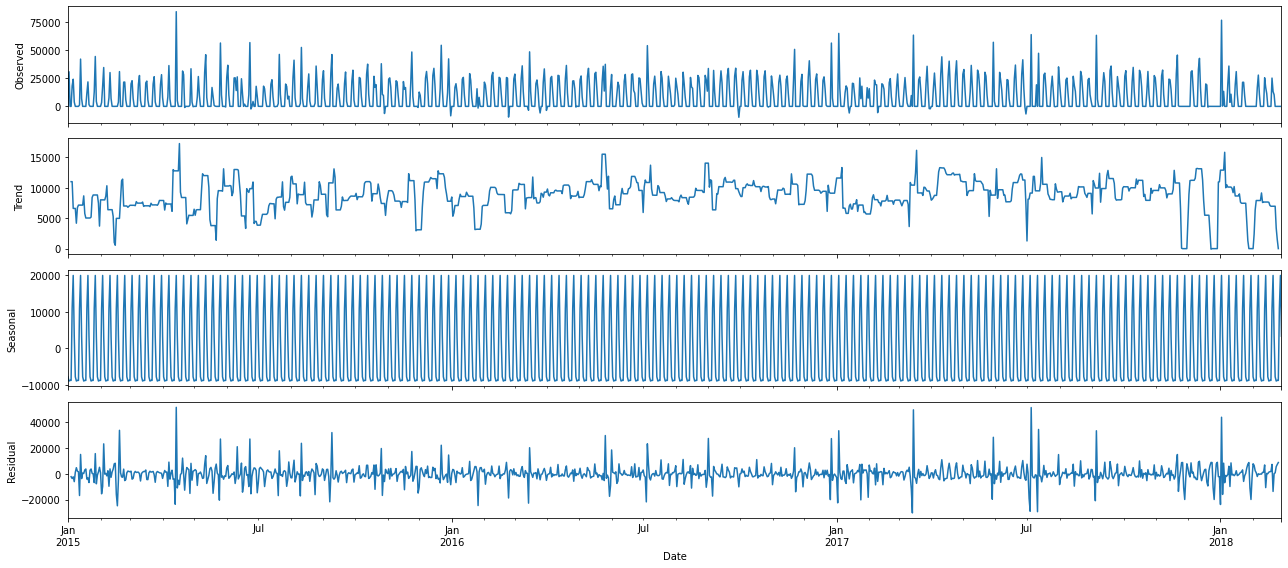

In [65]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_complete, model='additive', freq=7)
fig = decomposition.plot()
plt.show()

lets take a look at it for just one year

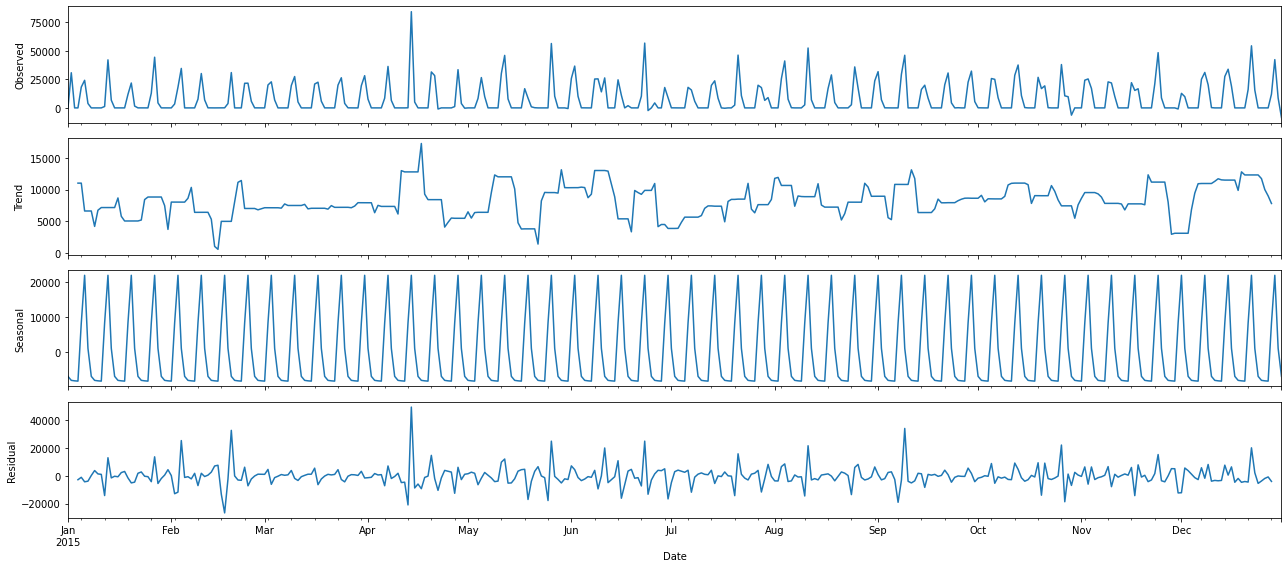

In [66]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_complete[:pd.to_datetime("2015-12-31")], model='additive', freq=7)
fig = decomposition.plot()
plt.show()

We can observe a clear seasonal pattern and unstable behaviour. It looks like the seasonal pattern is weekly.
which was to be expected after adding 0 values on weekends.

We obtain a p value that is < 0.5. So we can reject the null hypothesis that it has unit roots.

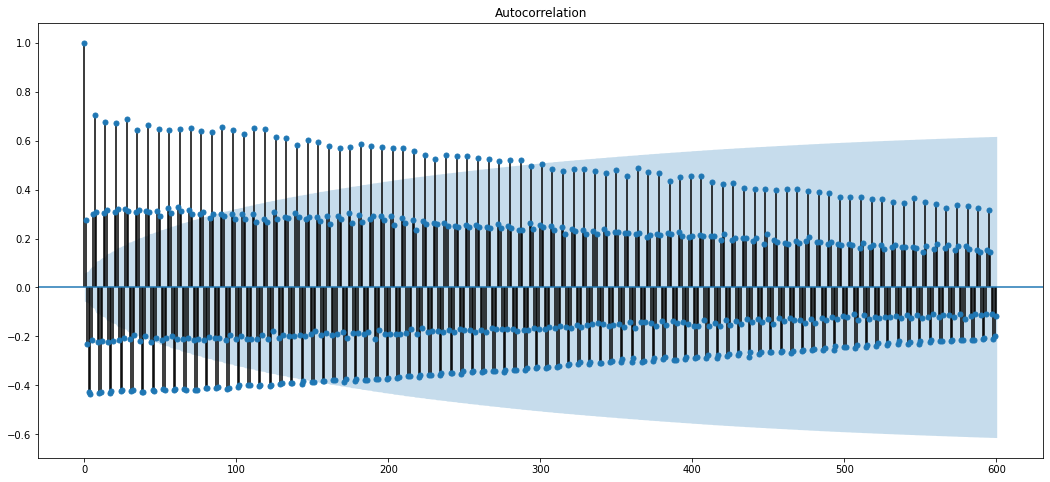

In [67]:
acf_plot = plot_acf(y_complete, lags=600)

We can observe autocorelation.


/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


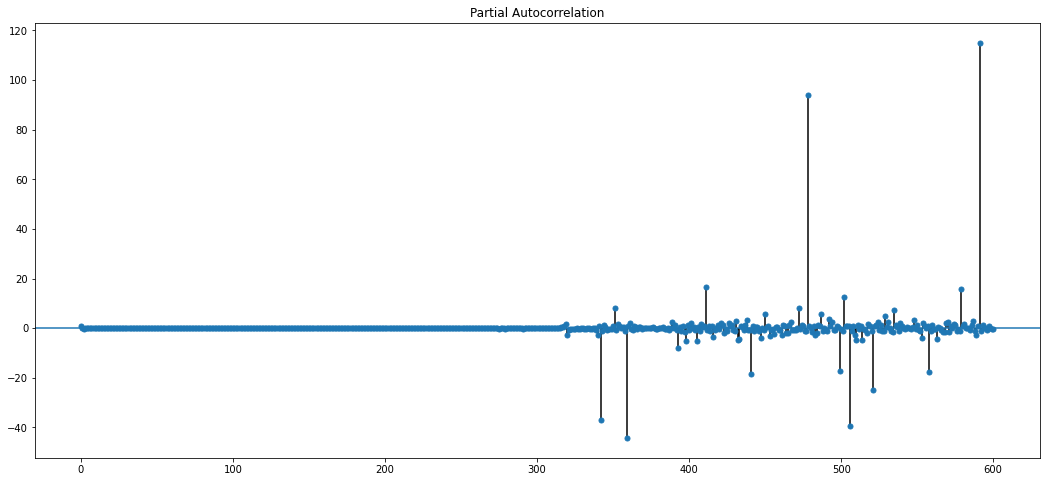

In [68]:
pacf_plot = plot_pacf(y, lags= 600)

We can observe more significant lags after approximately 350 lags, this hints to seasonality, with a yearly pattern. 


# Build ARMA Model for time series with gaps

since by the 15th of november we don´t know yet what will happen in the future, we can´t use future data neither for training nor for testing. We will therefor use 2017 as the testing year.
We are trying out an ARMA(5,1) Model, as we could see 5 significant ACT values.

In [69]:
train_end = pd.to_datetime("2017-07-01")
test_end = pd.to_datetime("2017-11-15")

train_data = y[:train_end]
test_data = y[train_end:test_end]

print(train_data.shape)
print(test_data.shape)

(517,)
(75,)


In [70]:
# define model,
model = ARMA(train_data, order=(5,1))
#fit the model

model_fit = model.fit()

#summary of the model
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:            Daily Sales   No. Observations:                  517
Model:                     ARMA(5, 1)   Log Likelihood               -5601.430
Method:                       css-mle   S.D. of innovations          12270.620
Date:                Mon, 06 Jun 2022   AIC                          11218.860
Time:                        20:54:07   BIC                          11252.845
Sample:                             0   HQIC                         11232.177
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.558e+04    386.657     40.292      0.000    1.48e+04    1.63e+04
ar.L1.Daily Sales     0.0202      0.587      0.034      0.973      -1.131       1.171
ar.L2.Daily Sales    -0.

#Build Seasonal ARIMA Model for complete time series

we have seen clear seasonal patterns in the model, so lets try SARIMA

"A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA […] The seasonal part of the model consists of terms that are very similar to the non-seasonal components of the model, but they involve backshifts of the seasonal period."

— Page 242, Forecasting: principles and practice, 2013.

"A seasonal ARIMA model uses differencing at a lag equal to the number of seasons (s) to remove additive seasonal effects. As with lag 1 differencing to remove a trend, the lag s differencing introduces a moving average term. The seasonal ARIMA model includes autoregressive and moving average terms at lag s."

— Page 142, Introductory Time Series with R, 2009.

ARIMA(p, d, q), these three parameters account for seasonality, trend, and noise in datasets:

* p Trend autoregression order. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
* d Trend difference order. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
* q Trend moving average order. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.


since we observed seasonality we will try seasonal  ARIMA(p,d,q)(P,D,Q)s
* (P, D, Q) follow the same definition as (p,dq) but are applied to the seasonal component of the time series. 
* The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

##Grid Search

In [71]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)
SARIMAX: (0, 1, 0) x (1, 0, 0, 7)


To find optimal parameters we will use Grid search:

In [72]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_complete[:test_end],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:23278.19675910055


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:22699.270315847516
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:22078.844132789152


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:21422.006568280805
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:21999.638793066006


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:21586.28038657674
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:21703.655085376555


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:21416.796898668974
ARIMA(0, 0, 1)x(0, 0, 0, 7)7 - AIC:22954.8653568568


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 7)7 - AIC:22511.507276745764
ARIMA(0, 0, 1)x(0, 1, 0, 7)7 - AIC:22020.928795276388


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 7)7 - AIC:21477.40457816556
ARIMA(0, 0, 1)x(1, 0, 0, 7)7 - AIC:22266.834675938644


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 7)7 - AIC:22078.619454526342


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 7)7 - AIC:21695.73431261966


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 7)7 - AIC:21475.793104376244
ARIMA(0, 1, 0)x(0, 0, 0, 7)7 - AIC:23242.586248783606


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 7)7 - AIC:22864.421422929983
ARIMA(0, 1, 0)x(0, 1, 0, 7)7 - AIC:22923.134148925976


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 7)7 - AIC:22299.479838264117
ARIMA(0, 1, 0)x(1, 0, 0, 7)7 - AIC:22696.315874825985


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 7)7 - AIC:22429.05762920521
ARIMA(0, 1, 0)x(1, 1, 0, 7)7 - AIC:22565.13438771535


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 7)7 - AIC:22267.931921796564
ARIMA(0, 1, 1)x(0, 0, 0, 7)7 - AIC:22899.26693737106


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 7)7 - AIC:22496.93711002542


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 7)7 - AIC:22063.83258386027


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 7)7 - AIC:21606.53304504281


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 7)7 - AIC:22374.828969666807


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 7)7 - AIC:22236.04806225154


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 7)7 - AIC:21793.475150436563


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 7)7 - AIC:21604.131535449134
ARIMA(1, 0, 0)x(0, 0, 0, 7)7 - AIC:22971.58724941987
ARIMA(1, 0, 0)x(0, 0, 1, 7)7 - AIC:22524.09454560186


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 7)7 - AIC:22056.397739418448


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 7)7 - AIC:21394.454481096625
ARIMA(1, 0, 0)x(1, 0, 0, 7)7 - AIC:22240.23927013228


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 7)7 - AIC:22093.052628675963


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 7)7 - AIC:21683.673877706235


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 7)7 - AIC:21503.72214764174
ARIMA(1, 0, 1)x(0, 0, 0, 7)7 - AIC:22926.790907416267


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 7)7 - AIC:22496.613276357075


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 7)7 - AIC:21953.006189742813


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 7)7 - AIC:21470.861815564385


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 7)7 - AIC:22226.21967911815


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 7)7 - AIC:22053.050842867742


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 7)7 - AIC:21650.01931049947


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 7)7 - AIC:21465.37447435724
ARIMA(1, 1, 0)x(0, 0, 0, 7)7 - AIC:23224.25979788442


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 7)7 - AIC:22799.533352189348
ARIMA(1, 1, 0)x(0, 1, 0, 7)7 - AIC:22571.95636365528


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 7)7 - AIC:22017.35897524797


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 7)7 - AIC:22422.17668096256


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 7)7 - AIC:22432.50260538275


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 7)7 - AIC:22210.808091887262


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 7)7 - AIC:22012.679294970745


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 0, 7)7 - AIC:22816.14768409871


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 7)7 - AIC:22450.37127588882


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 7)7 - AIC:22046.33281455202


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 7)7 - AIC:21597.10244260046


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 7)7 - AIC:22302.53522136194


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 7)7 - AIC:22177.57424266541


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 7)7 - AIC:21753.175308183192


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 7)7 - AIC:21595.195839409796


That didnt work out well. Out of curiosity we will try one of them.
Looking at the AIC values these choices of parameters seem to be the best:
*   ARIMA(1, 0, 1)x(1, 1, 1, 7)7 - AIC:21465.37447435724









In [75]:
mod_1 = sm.tsa.statespace.SARIMAX(y_complete[:test_end],
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_1 = mod_1.fit()
print(results_1.aic)
print(results_1)
print(results_1.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


21465.37447435724
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7455      0.068     10.902      0.000       0.611       0.879
ma.L1         -0.8653      0.058    -14.963      0.000      -0.979      -0.752
ar.S.L7        0.1309      0.036      3.590      0.000       0.059       0.202
ma.S.L7       -0.9035      0.014    -62.339      0.000      -0.932      -0.875
sigma2      8.963e+07   9.17e-11   9.77e+17      0.000    8.96e+07    8.96e+07


another try based on ACF and PACF plots

In [82]:
#ARIMA(2, 2, 2)x(1, 1, 0, 12)12 
mod_2 = sm.tsa.statespace.SARIMAX(y_complete[:test_end],
                                order=(3, 1, 5),
                                seasonal_order=(1, 1, 0, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_2 = mod_2.fit()
print(results_2.aic)
print(results_2)
print(results_2.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21618.819894760978
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7515      0.512     -1.468      0.142      -1.755       0.252
ar.L2         -0.9710      0.206     -4.707      0.000      -1.375      -0.567
ar.L3         -0.3027      0.441     -0.687      0.492      -1.166       0.561
ma.L1         -0.4163      0.508     -0.820      0.412      -1.411       0.579
ma.L2          0.2536      0.389      0.653      0.514      -0.508       1.015
ma.L3         -0.7934      0.337     -2.355      0.019      -1.454      -0.133
ma.L4         -0.2579      0.562     -0.459      0.646      -1.359       0.843
ma.L5          0.2166      0.115      1.889      0.059      -0.008       0.441
ar.S.L7       -0.4347      0.031    -13.951      0.000      -0.496      -0.374
sigma2      1.045e+08   8.43e-09   1.24e+16      0.000    1.04e+08    1.04e+08


In [83]:
#and another try
mod_3 = sm.tsa.statespace.SARIMAX(y_complete[:test_end],
                                order=(3, 1, 3),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_3 = mod_3.fit()
print(results_3.aic)
print(results_3)
print(results_3.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21525.380157708656
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6747      0.465     -1.450      0.147      -1.587       0.237
ar.L2          0.2899      0.562      0.516      0.606      -0.811       1.390
ar.L3         -0.0315      0.121     -0.260      0.795      -0.269       0.206
ma.L1         -0.4880      0.468     -1.043      0.297      -1.405       0.429
ma.L2         -0.9896      0.039    -25.381      0.000      -1.066      -0.913
ma.L3          0.4877      0.459      1.062      0.288      -0.413       1.388
ar.S.L7        0.0990      0.049      2.012      0.044       0.003       0.196
ma.S.L7       -0.8942      0.022    -40.548      0.000      -0.937      -0.851
sigma2       1.12e+08   4.12e-09   2.72e+16      0.000    1.12e+08    1.12e+08


In [84]:
mod_4 = sm.tsa.statespace.SARIMAX(y_complete[:test_end],
                                order=(3, 1, 5),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_4 = mod_4.fit()
print(results_4.aic)
print(results_4)
print(results_4.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21448.97994060997
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4035      0.147     -2.736      0.006      -0.693      -0.114
ar.L2         -0.1916      0.163     -1.175      0.240      -0.511       0.128
ar.L3          0.7119      0.149      4.794      0.000       0.421       1.003
ma.L1         -0.7602      0.160     -4.738      0.000      -1.075      -0.446
ma.L2         -0.1781      0.073     -2.442      0.015      -0.321      -0.035
ma.L3         -0.8836      0.055    -16.154      0.000      -0.991      -0.776
ma.L4          0.8718      0.156      5.597      0.000       0.566       1.177
ma.L5         -0.0473      0.073     -0.649      0.517      -0.190       0.096
ar.S.L7        0.1162      0.046      2.548      0.011       0.027       0.206
ma.S.L7       -0.9011      0.020    -45.070      0.000      -0.940      -0.862
sigma2      1.045e+08   7.32e-09  

We will stick to model 4 since it has the most statistcally significant coefficients.


#Evaluate Model


Let us forcast and evaluate the results

2017-11-15    15012.579837
2017-11-16     1005.043980
2017-11-17      -49.421729
2017-11-18      399.906632
2017-11-19      463.885691
                  ...     
2018-02-18      -50.632955
2018-02-19    23906.491734
2018-02-20    29179.341789
2018-02-21    14417.341659
2018-02-22      637.023062
Freq: D, Length: 100, dtype: float64


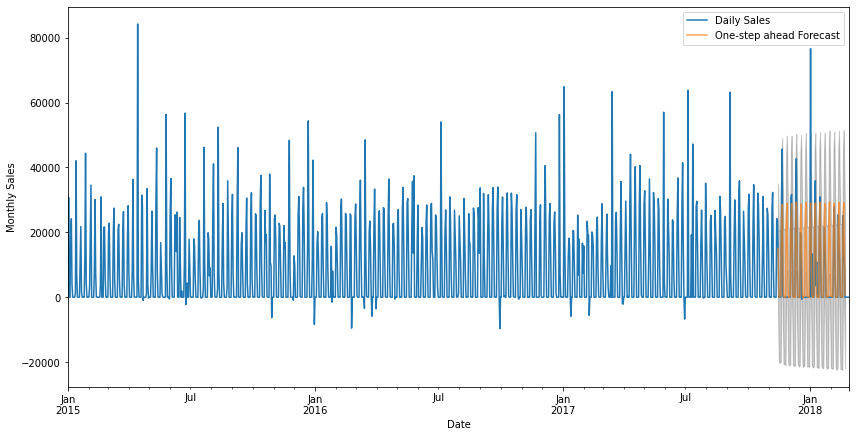

In [85]:
pred = results_4.get_prediction(start=pd.to_datetime('2017-11-15'), end=pd.to_datetime('2018-02-22'),dynamic=False)
pred_ci = pred.conf_int()
print(pred.predicted_mean)
ax = y_complete.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly Sales')
plt.legend()
plt.show()

this does not look to bad, most of the values fall into the confidence intervall.
Lets look at the specific forecast.

#Do the forecasting

##November 17

2017-11-16     1005.043980
2017-11-17      -49.421729
2017-11-18      399.906632
2017-11-19      463.885691
2017-11-20    23492.352181
2017-11-21    28647.331853
2017-11-22    14815.676303
Freq: D, dtype: float64


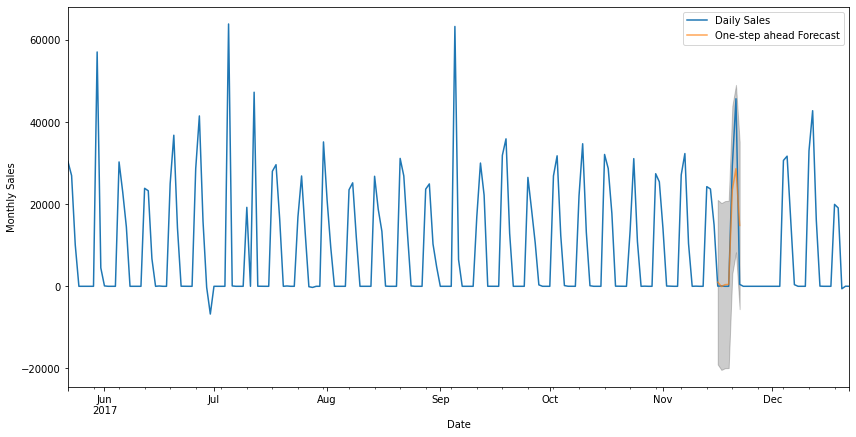

In [112]:
nov_1 = predict(model = results_4, start_string = '2017-11-16', end_string = '2017-11-22', series = y_complete)

It captures the trend and lies in conf-intervall.
For the next day we want to take real values in account so we retrain the model with the same parameters.

In [115]:
mod_nov2 = built_SARIMA(order=(3, 1, 5),seasonal_order=(1, 1, 1, 7), series= y_complete[:pd.to_datetime('2017-11-16')])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21468.861716734697
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3996      0.143     -2.793      0.005      -0.680      -0.119
ar.L2         -0.1845      0.160     -1.155      0.248      -0.497       0.128
ar.L3          0.7183      0.145      4.945      0.000       0.434       1.003
ma.L1         -0.7597      0.156     -4.866      0.000      -1.066      -0.454
ma.L2         -0.1835      0.071     -2.571      0.010      -0.323      -0.044
ma.L3         -0.8831      0.053    -16.630      0.000      -0.987      -0.779
ma.L4          0.8727      0.153      5.702      0.000       0.573       1.173
ma.L5         -0.0442      0.072     -0.611      0.541      -0.186       0.098
ar.S.L7        0.1127      0.046      2.467      0.014       0.023       0.202
ma.S.L7       -0.8975      0.021    -43.365      0.000      -0.938      -0.857
sigma2      1.044e+08   6.91e-09 

2017-11-17      110.059862
2017-11-18      417.675831
2017-11-19      595.260138
2017-11-20    23544.058552
2017-11-21    28658.707219
2017-11-22    14862.418164
Freq: D, dtype: float64


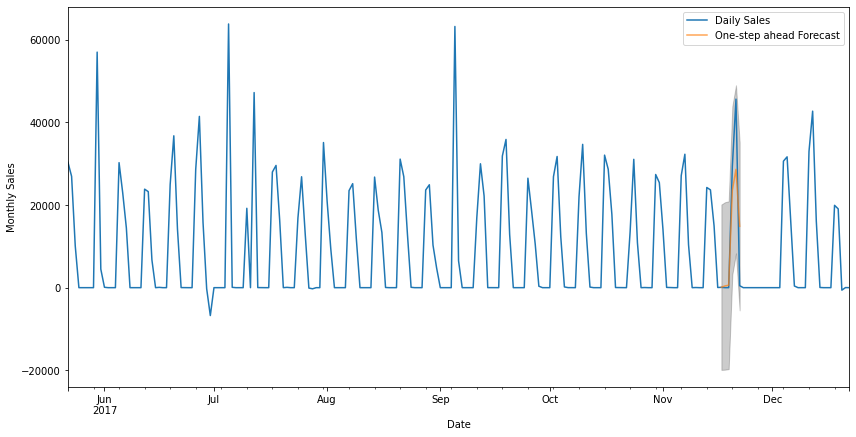

In [116]:
nov_2 = predict(model = mod_nov2, start_string = '2017-11-17', end_string = '2017-11-22', series = y_complete)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21488.68114965535
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4044      0.146     -2.762      0.006      -0.691      -0.117
ar.L2         -0.1923      0.162     -1.187      0.235      -0.510       0.125
ar.L3          0.7109      0.146      4.860      0.000       0.424       0.998
ma.L1         -0.7543      0.160     -4.729      0.000      -1.067      -0.442
ma.L2         -0.1823      0.070     -2.606      0.009      -0.319      -0.045
ma.L3         -0.8852      0.049    -17.974      0.000      -0.982      -0.789
ma.L4          0.8665      0.153      5.655      0.000       0.566       1.167
ma.L5         -0.0423      0.073     -0.583      0.560      -0.185       0.100
ar.S.L7        0.1090      0.046      2.393      0.017       0.020       0.198
ma.S.L7       -0.8982      0.020    -43.851      0.000      -0.938      -0.858
sigma2      1.043e+08   7.52e-09  

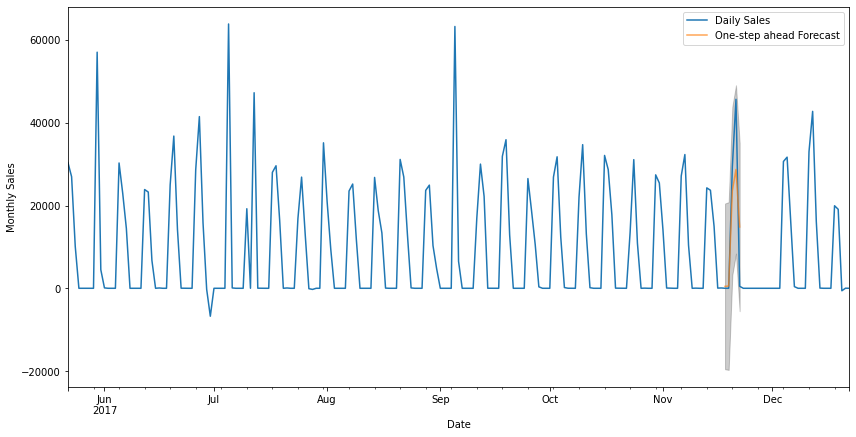

In [119]:
nov_3 =make_forcast(start_date="2017-11-18", end_date_train='2017-11-17', end_forecast= '2017-11-22')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21508.696411273122
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4283      0.155     -2.768      0.006      -0.732      -0.125
ar.L2         -0.1952      0.172     -1.134      0.257      -0.532       0.142
ar.L3          0.7019      0.155      4.522      0.000       0.398       1.006
ma.L1         -0.7446      0.167     -4.451      0.000      -1.073      -0.417
ma.L2         -0.1990      0.075     -2.670      0.008      -0.345      -0.053
ma.L3         -0.8696      0.051    -16.963      0.000      -0.970      -0.769
ma.L4          0.8690      0.162      5.361      0.000       0.551       1.187
ma.L5         -0.0531      0.075     -0.708      0.479      -0.200       0.094
ar.S.L7        0.1154      0.046      2.533      0.011       0.026       0.205
ma.S.L7       -0.9012      0.020    -45.099      0.000      -0.940      -0.862
sigma2      1.042e+08   7.89e-09 

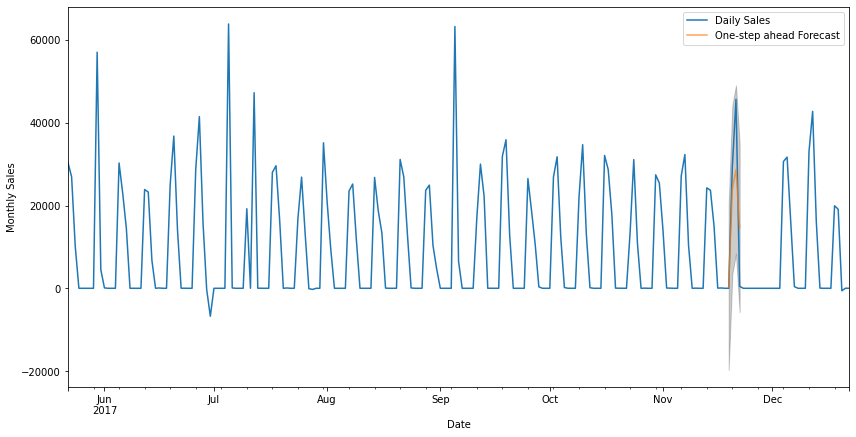

In [123]:
nov_4=make_forcast(start_date="2017-11-19", end_date_train='2017-11-18', end_forecast= '2017-11-22')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21528.18256934262
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4051      0.145     -2.787      0.005      -0.690      -0.120
ar.L2         -0.1915      0.162     -1.184      0.236      -0.508       0.125
ar.L3          0.7118      0.147      4.853      0.000       0.424       0.999
ma.L1         -0.7655      0.158     -4.837      0.000      -1.076      -0.455
ma.L2         -0.1754      0.071     -2.468      0.014      -0.315      -0.036
ma.L3         -0.8818      0.051    -17.147      0.000      -0.983      -0.781
ma.L4          0.8770      0.154      5.703      0.000       0.576       1.178
ma.L5         -0.0520      0.073     -0.712      0.476      -0.195       0.091
ar.S.L7        0.1181      0.045      2.596      0.009       0.029       0.207
ma.S.L7       -0.9024      0.020    -45.943      0.000      -0.941      -0.864
sigma2      1.041e+08   7.24e-09  

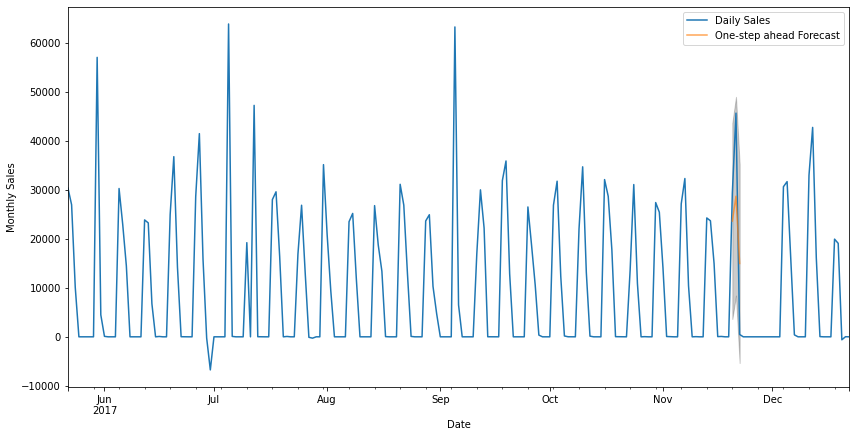

In [124]:
nov_5= make_forcast(start_date="2017-11-20", end_date_train='2017-11-19', end_forecast= '2017-11-22')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


21508.696411273122
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4283      0.155     -2.768      0.006      -0.732      -0.125
ar.L2         -0.1952      0.172     -1.134      0.257      -0.532       0.142
ar.L3          0.7019      0.155      4.522      0.000       0.398       1.006
ma.L1         -0.7446      0.167     -4.451      0.000      -1.073      -0.417
ma.L2         -0.1990      0.075     -2.670      0.008      -0.345      -0.053
ma.L3         -0.8696      0.051    -16.963      0.000      -0.970      -0.769
ma.L4          0.8690      0.162      5.361      0.000       0.551       1.187
ma.L5         -0.0531      0.075     -0.708      0.479      -0.200       0.094
ar.S.L7        0.1154      0.046      2.533      0.011       0.026       0.205
ma.S.L7       -0.9012      0.020    -45.099      0.000      -0.940      -0.862
sigma2      1.042e+08   7.89e-09 

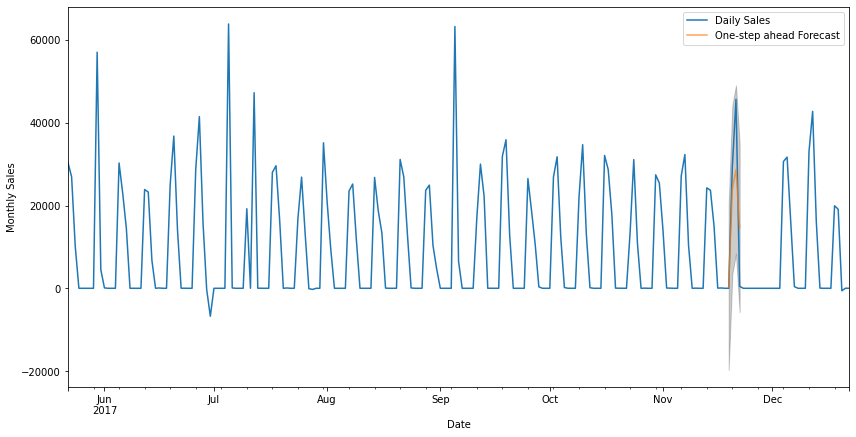

In [125]:
nov_6 = make_forcast(start_date="2017-11-19", end_date_train='2017-11-18', end_forecast= '2017-11-22')

lets look at the confidence intervals:

In [134]:
nov_1.conf_int()

,lower Daily Sales,upper Daily Sales
2017-11-16,-19031.087345,21041.175305
2017-11-17,-20352.586209,20253.742750
2017-11-18,-19943.571921,20743.385185
2017-11-19,-19907.085223,20834.856604
2017-11-20,3110.504702,43874.199659
2017-11-21,8261.821782,49032.841923
2017-11-22,-5574.116400,35205.469006


In [135]:
nov_1.predicted_mean

2017-11-16     1005.043980
2017-11-17      -49.421729
2017-11-18      399.906632
2017-11-19      463.885691
2017-11-20    23492.352181
2017-11-21    28647.331853
2017-11-22    14815.676303
Freq: D, dtype: float64

we can observe that they all lie in confidence interval. Lets calculate the sum of the daily sales together with the predictions.
First sum up the past sales:

In [148]:
past_sum = y_complete[:pd.to_datetime('2017-11-16')].sum()
past_sum

Daily Sales    9385506.006
dtype: float64

The confidence intervals can also be summed up.

In [138]:
nov_1.conf_int().sum()

lower Daily Sales    -73436.120613
upper Daily Sales    210985.670432
dtype: float64

In [149]:
nov_1.conf_int().sum()+past_sum[0]

lower Daily Sales    9.312070e+06
upper Daily Sales    9.596492e+06
dtype: float64

In [150]:
nov_1.predicted_mean.sum()+past_sum[0]

9454280.780909467

this same procedure we could apply for the other times that should be forecasted.
It is left to deal with the difference of the actual sales and the sum of daily sales.
If there was more time, I would try a simple NN or a regression on X=(predicted sum daily, sales, distance to end of month, LO ) with Y = actual sales to predict the actual sales instead of the sum of daily sales, as done now.
Or maybe I would change the time series in something that takes the actual sales n account.